In [1]:
import sys
sys.path.append("../")
from evaluation import main
from data_processor import DataProcessor
import numpy as np
import os

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pip install -q --proxy http://proxy:80 scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


Download test datasets from here: https://github.com/Towers-D/NAS-Unseen-Datasets

In [2]:
#Dataset must be in the folder datasets
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = main.load_datasets("AddNIST", truncate=False)

In [3]:
#AddNIST
metadata["rand_augment"]=False

In [4]:
data_processor = DataProcessor(train_x, train_y, valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()

[RandomCrop(size=(28, 28), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5)]
[Normalize(mean=[tensor(0.0053), tensor(0.0066), tensor(0.0077)], std=[tensor(1.0065), tensor(1.0080), tensor(1.0092)], inplace=False)]
[Normalize(mean=[tensor(0.0053), tensor(0.0066), tensor(0.0077)], std=[tensor(1.0065), tensor(1.0080), tensor(1.0092)], inplace=False)]


In [5]:
import torch
def check_normalization(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data,_ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    print(f'Mean: {mean}')
    print(f'Std: {std}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


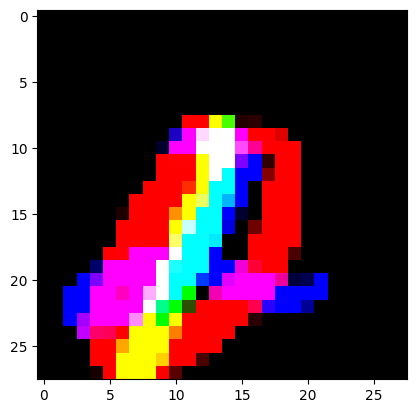

In [6]:
import matplotlib.pyplot as plt
img=next(iter(train_loader))[0][30]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

In [5]:
from search_space.RegNet import RegNet
import torch
import random
import numpy as np
import time
from IPython.display import clear_output
random_seed = 42
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
metadata

{'num_classes': 20,
 'input_shape': [50000, 3, 28, 28],
 'codename': 'Adaline',
 'benchmark': 89.85,
 'rand_augment': False}

In [6]:
space_regnet=RegNet(metadata, W0=[8, 56, 8], WA=[8, 48, 8],WM=[2.0,2.9,0.05],D=[6,20,1])

In [7]:
update_list=[
    "REGNET.SE_ON",False,
    "REGNET.BLOCK_TYPE","res_bottleneck_block"
]

model,info=space_regnet.load_model(config_file="tests_one_model/Generation_1_SE/quizzical_caiman/config.yaml", 
                                   config_updates=update_list)


res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'stem_type': 'res_stem_cifar', 'stem_w': 32, 'block_type': 'res_bottleneck_block', 'depths': [1, 3, 9, 2], 'widths': [56, 152, 392, 1040], 'strides': [2, 2, 2, 2], 'bot_muls': [1.0, 1.0, 1.0, 1.0], 'group_ws': [8, 8, 8, 8], 'head_w': 0, 'se_r': 0, 'num_classes': 20, 'downsample': 'avg', 'drop_path_rate': 0.0}
Loading model: tests_one_model/Generation_1_SE/quizzical_caiman/config.yaml
res_bottleneck_block


In [13]:
from torchsummary import summary
summary(model, (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             864
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
      ResStemCifar-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 56, 14, 14]           1,792
       BatchNorm2d-6           [-1, 56, 14, 14]             112
            Conv2d-7           [-1, 56, 14, 14]          16,128
       BatchNorm2d-8           [-1, 56, 14, 14]             112
              ReLU-9           [-1, 56, 14, 14]               0
           Conv2d-10           [-1, 56, 14, 14]          28,224
      BatchNorm2d-11           [-1, 56, 14, 14]             112
   BasicTransform-12           [-1, 56, 14, 14]               0
             ReLU-13           [-1, 56, 14, 14]               0
    ResBasicBlock-14           [-1, 56,

In [9]:
info

{'ws': [56, 152, 392, 1040],
 'bs': [1.0, 1.0, 1.0, 1.0],
 'gs': [8, 8, 8, 8],
 'ds': [1, 3, 9, 2],
 'num_stages': 4,
 'total_size_mb': None,
 'h': 1,
 'w': 1,
 'flops': 20820,
 'params': 7433268,
 'acts': 20,
 'WA': 48.0,
 'W0': 56,
 'WM': 2.6499999999999977,
 'DEPTH': 15}

In [8]:
from trainer import Trainer, TrainerDistillation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student="quizzical_caiman"
metadata["experiment_name"]=f"tests_one_model/Generation_1_01/{student}_NOSE_D"
trainer=TrainerDistillation(model, device, train_loader, valid_loader, metadata)
trainer.train()

[TRAIN] Epoch:1| Time(data):0.000| Time(train):0.057| Loss:2.7066| Top-1:13.562| Top-5:48.818: 100%|██████████| 703/703 [01:01<00:00, 11.48it/s]
[EVAL] Top-1:14.673| Top-5:51.353: 100%|██████████| 235/235 [00:07<00:00, 33.07it/s]
[TRAIN] Epoch:2| Time(data):0.000| Time(train):0.057| Loss:2.2890| Top-1:22.720| Top-5:64.049: 100%|██████████| 703/703 [01:01<00:00, 11.52it/s]
[EVAL] Top-1:24.193| Top-5:66.313: 100%|██████████| 235/235 [00:07<00:00, 33.46it/s]
[TRAIN] Epoch:3| Time(data):0.000| Time(train):0.057| Loss:2.0922| Top-1:29.087| Top-5:71.033: 100%|██████████| 703/703 [01:01<00:00, 11.52it/s]
[EVAL] Top-1:28.280| Top-5:65.707: 100%|██████████| 235/235 [00:07<00:00, 33.54it/s]
[TRAIN] Epoch:4| Time(data):0.000| Time(train):0.058| Loss:1.9225| Top-1:35.173| Top-5:76.645: 100%|██████████| 703/703 [01:01<00:00, 11.42it/s]
[EVAL] Top-1:33.507| Top-5:72.880: 100%|██████████| 235/235 [00:07<00:00, 32.77it/s]
[TRAIN] Epoch:5| Time(data):0.000| Time(train):0.058| Loss:1.7505| Top-1:41.092|

[EVAL] Best accuracy:86.31999969482422


RegNet(
  (stem): ResStemCifar(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (af): ReLU(inplace=True)
  )
  (s1): AnyStage(
    (b1): ResBottleneckBlock(
      (f): BottleneckTransform(
        (a): Conv2d(32, 56, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (a_af): ReLU(inplace=True)
        (b): Conv2d(56, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=7, bias=False)
        (b_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (b_af): ReLU(inplace=True)
        (c): Conv2d(56, 56, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (c_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (af): ReLU(inplace=True)
      (downsample): Sequenti